In [221]:
import math
import glob
import os
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt


def replic_pad(Igs,size):
    H,W = Igs.shape
    h,w = size 
    h2,w2 = h//2, w//2
    padded = np.zeros((H+2*h2,W+2*w2))
    padded[h2:H+h2,w2:W+w2] = Igs[:,:].copy()
    
    for i in range(0,h2):
        padded[i,:] = padded[h2,:]
        padded[H+2*h2-1-i,:] = padded[H+h2-1,:]

    for j in range(0,w2):
        padded[:,j] = padded[:,w2].copy()
        padded[:,W+2*w2-1-j] = padded[:,W+w2-1]       
    return padded  
    

def ConvFilter(Igs, G):
    for s in G.shape:
        if s % 2 == 0:
            raise Exception("Kernel size must be odd")
    
    h, w = G.shape 
    h2, w2 = h//2, w//2
    padded = replic_pad(Igs.copy(), G.shape)
    H, W = padded.shape 
        
    #flip kernel
    for i in range(h2):
        G[i,:], G[2*h2-i,:] = G[2*h2-i,:].copy(), G[i,:].copy()
    for j in range(w2):
        G[:,j], G[:,2*w2-j] = G[:,2*w2-j].copy(), G[:,j].copy()
       
    #convolve
    Iconv = np.zeros(Igs.shape)   
    for i in range(h2,H-h2):
        for j in range(w2,W-w2):
            sum = 0
            for k in range(h):
                for l in range(w):
                    sum += padded[i-h2+k,j-w2+l]*G[k,l]
            Iconv[i-h2,j-w2] = sum
    
    return Iconv

def GaussianFilter(Igs,sigma,size):
    
    h,w = size
    h2,w2 = h//2, w//2
    
    col = np.zeros((h,1))
    row = np.zeros((1,w))
    colsum, rowsum = 0, 0
    col1 = math.exp(-math.pow(-h2,2)/(2*math.pow(sigma,2)))/(math.sqrt(2*math.pi)*sigma)
    row1 = math.exp(-math.pow(-w2,2)/(2*math.pow(sigma,2)))/(math.sqrt(2*math.pi)*sigma)
   
    for i in range(h):
        col[i,:] = math.exp(-math.pow(i-h2,2)/(2*math.pow(sigma,2)))/(math.sqrt(2*math.pi)*sigma)
        col[i,:] = np.round(col[i,:]/col1)
        colsum += col[i,:]       
    for j in range(w):
        row[:,j] = math.exp(-math.pow(j-w2,2)/(2*math.pow(sigma,2)))/(math.sqrt(2*math.pi)*sigma)
        row[:,j] = np.round(row[:,j]/row1) 
        rowsum += row[:,j]

    gaussian = np.zeros(Igs.shape)
    gaussian = ConvFilter(ConvFilter(Igs.copy(),col),row)

    return gaussian/(rowsum*colsum)

def NMS(Im,Io):
    
    H,W = Im.shape
    nms = Im.copy()
       
    for i in range(0,H):
        for j in range(0,W):
            if (i !=0 and j !=0 and i != H-1 and j != W-1):
                if (Io[i,j] < 0 ):
                    Io[i,j] += 180
                if (0 <= Io[i,j] < 22.5 or 157.5 <= Io[i,j] <= 180):
                    if(nms[i ,j] < nms[i,j-1] or nms[i,j] < nms[i,j+1]):
                        nms[i,j] = 0
                elif (22.5 <= Io[i,j] < 67.5):
                    if(nms[i,j] < nms[i-1,j-1] or nms[i,j] < nms[i+1,j+1]):
                        nms[i,j] = 0
                elif (67.5 <= Io[i,j] < 112.5):
                    if(nms[i,j] < nms[i-1,j] or nms[i,j] < nms[i+1,j]):
                        nms[i,j] = 0
                elif (112.5 <= Io[i,j] < 157.5):
                    if(nms[i,j] < nms[i+1,j-1] or nms[i,j] < nms[i-1,j+1]):
                        nms[i,j] = 0
            else:
                nms[i,j] = 0
    
    return nms

            
def doubleTH(Im, highThreshold, lowThreshold):
    
    H,W = Im.shape
    highTH = Im.max()*highThreshold
    lowTH = highTH*lowThreshold
    TH = np.zeros(Im.shape)
    strong_edge = 1
    weak_edge = 0.5
    str_num = 0
    weak_num = 0
    
    #double Threshold
    for i in range(H):
        for j in range(W):
            if (Im[i,j] >= highTH):
                TH[i,j] = strong_edge
                str_num += 1 
            elif (Im[i,j] < highTH and Im[i,j] >= lowTH):
                TH[i,j] = weak_edge
                weak_num += 1 
    print("총", H*W,"strong",str_num,"weak",weak_num)
    
    str_num2 = 0
    #Hysteresis based
    hys = TH.copy()           
    for i in range(0,H):
        for j in range(0,W):
            if (i!=0 and i!=H-1 and j!=0 and j!=W-1):
                if (TH[i,j] == weak_edge):
                    if ((TH[i,j-1] == strong_edge) or
                        (TH[i-1,j-1] == strong_edge) or
                        (TH[i-1,j] == strong_edge) or
                        (TH[i-1,j+1] == strong_edge) or
                        (TH[i,j+1] == strong_edge) or
                        (TH[i+1,j+1] == strong_edge) or
                        (TH[i+1,j] == strong_edge) or
                        (TH[i+1,j-1] == strong_edge)):
                        hys[i,j] = strong_edge
                        str_num2 += 1
                    else:
                        hys[i,j] = 0
            else:
                hys[i,j] = 0
    print(weak_num,"중",str_num2,"개 strong에 추가")
                    
    return hys
                
    
    
def EdgeDetection(Igs, sigma, highThreshold, lowThreshold):
    
    sblx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]],np.float32)
    sbly = np.array([[-1,-2,-1],[0,0,0],[1,2,1]],np.float32)
    
    smoothed = GaussianFilter(Igs.copy(),sigma,Gaussian_size)

    Ix = ConvFilter(smoothed,sblx)
    Iy = ConvFilter(smoothed,sbly)
    
    Io = np.zeros(smoothed.shape)
    Io = np.arctan2(Iy,Ix)*180/math.pi
    
    Im = np.zeros(smoothed.shape)
    for i in range(smoothed.shape[0]):
        for j in range(smoothed.shape[1]):
            Im[i,j] = math.sqrt(math.pow(Ix[i,j],2)+math.pow(Iy[i,j],2))
    Im = Im/Im.max()
    
    Im = NMS(Im,Io)
    Im = doubleTH(Im,highThreshold,lowThreshold)
    
    return Im, Io, Ix, Iy

def HoughTransform(Im, rhoRes, thetaRes):
    
    H,W = Im.shape    
    rho_max = math.ceil(math.sqrt(H*H + W*W))
    theta_max = 360                       
    rho = np.arange(0,rho_max,rhoRes)
    theta = np.arange(0,theta_max, thetaRes)
    
    cos_ = np.cos(theta*math.pi/180)
    sin_ = np.sin(theta*math.pi/180)
    rho_len = len(rho)
    theta_len = len(theta)

    acc = np.zeros((rho_len,theta_len))
    for i in range(H):
        for j in range(W):
            if (Im[i,j] != 0):
                for theta_index in range(theta_len):
                    rho_ = round(j*cos_[theta_index]+i*sin_[theta_index]) #실제 rho 값
                    if (0<= rho_ <=rho_max):
                        acc[rho_//rhoRes,theta_index] += 1

    return acc

def HoughLines(H,rhoRes,thetaRes,nLines,rhoTh,thetaTh):

    rth = rhoTh
    tth = thetaTh
    h,w = H.shape
    nonzero = np.transpose(np.nonzero(H))
    theta_max = 360
    theta = np.arange(0,theta_max,thetaRes) #실제 theta
    
    for nz in nonzero:
        U = nz[0]-rth
        D = nz[0]+rth+1        
        L = nz[1]-tth
        R = nz[1]+tth+1
        c = np.arange(L,R,1)
        if (U < 0):
            U = 0
        if (D > h):
            D = h            
        if (R > w):
            c = list(range(L,w,1))+list(range(0,R-w,1))
        H[nz[0],nz[1]] -= 1    
        if (np.any(H[U:D,c]>H[nz[0],nz[1]])):
            H[nz[0],nz[1]] = 0
        else:
            H[nz[0],nz[1]] += 1
                
    IRho, ITheta = np.unravel_index(np.argsort(-1*H,axis=None)[:nLines],H.shape) #rho, theta index 값들 array
    
    for i in range(len(IRho)):
        print(i+1,"번째로 큰 vote 수:", H[IRho[i],ITheta[i]],"(",IRho[i]*rhoRes,theta[ITheta[i]],")")
      
    return IRho,ITheta

def HoughLineSegments(IRho: list, ITheta: list, Im, interval):
    l = []      
    theta_max = 360
    interval = interval
    
    theta = np.arange(0,theta_max,thetaRes)
    nonzero = np.transpose(np.nonzero(Im))    
    cos_ = np.cos(theta*math.pi/180)
    sin_ = np.sin(theta*math.pi/180)  

    for line_num in range(len(IRho)):
        
        theta_ = ITheta[line_num] #theta index 값
        rho_ = IRho[line_num] #rho index 값
        point_list = [] #일단 edge 위의 모든 점을 point_list에 저장
        segment = []
        temp = []
        
        #기여한 x,y 좌표 찾기
        for point in nonzero:
                    if(rho_ == round(point[1]*cos_[theta_]+point[0]*sin_[theta_])//rhoRes):
                        point_list.append(point)
        point_list = sorted(point_list, key=lambda point_list: point_list[1]) #x값 기준으로 sort
        
        #segment 나누기
        for i in range(len(point_list)):
            if (i>0):
                if(abs(point_list[i][1] - point_list[i-1][1]) > interval or abs(point_list[i][0]-point_list[i-1][0]) > interval):
                    segment.append(temp)
                    temp = []
            temp.append(point_list[i])
        segment.append(temp)
        print("segment 개수", len(segment))
               
        #가장 긴 segment 찾기
        maxlist = [] #max(segment,key=len)
        max_len = 1 #최소 길이     
        for line in segment:
            if (len(line) < 2): continue
            line_length = math.sqrt(math.pow(line[0][0]-line[-1][0],2)+math.pow(line[0][1]-line[-1][1],2))
            if (line_length >= max_len):
                max_len = line_length
                maxlist = line
                
        if(len(maxlist)!=0):
            d = {'start':maxlist[0],'end':maxlist[-1]}
            l.append(d)
            print("직선",line_num+1,":",maxlist[0],maxlist[-1])
      
    return l

def drawhoughline(Igs,lRho,lTheta):
    for i in range(len(lRho)):
        theta_ = lTheta[i]*thetaRes*math.pi/180
        rho_ = lRho[i]*rhoRes
        line = []
        if (theta_ > 0):
            for x in range(1,Igs.shape[1]):
                y = -x/np.tan(theta_) + rho_/np.sin(theta_)
                if y > 0 and y < Igs.shape[0]:
                    line.append((x,y))
        elif (theta_ == 0):
            for y in range(1,Igs.shape[0]):
                x = rho_
                if x > 0 and x < Igs.shape[1]:
                    line.append((x,y))
        if len(line) > 0:
            print([line[0][0],line[-1][0]],[line[0][-1],line[-1][-1]])
            plt.plot([line[0][0],line[-1][0]],[line[0][-1],line[-1][-1]])
        elif len(line) == 0:
            print(i+1, "번째 IRho의 element에서는 line list가 비어잇음")   
            
def drawsegments(I):
    for i in range(len(I)):
        plt.plot([I[i]['start'][1],I[i]['end'][1]],[I[i]['start'][0],I[i]['end'][0]])

def parameters();
    # parameters
    datadir = './data'
    resultdir='./results'

    # edgedetection
    sigma=[1.0,1.0,1.0,1.0]
    Gaussian_size= (5,5)
    highThreshold=[0.23,0.23,0.23,0.23] #max에서 몇퍼센트
    lowThreshold=[0.5,0.5,0.5,0.5] #highThreshold에서 몇퍼센트

    #houghline
    rhoRes=[5,5,5,5]
    thetaRes=[5,5,5,5] 
    rhoTh=[5,5,5,5 ]  #rhoRes * rhoTh 만큼 non maximal suppression
    thetaTh=[5,5,5,5] #thetaRes * thetaTh 만큼 non maximal suppression
    interval=[10,10,10,10]
    nLines=20

총 249696 strong 4545 weak 2946
2946 중 424 개 strong에 추가
1 번째로 큰 vote 수: 338.0 ( 165 90 )
2 번째로 큰 vote 수: 230.0 ( 360 90 )
3 번째로 큰 vote 수: 206.0 ( 265 90 )
4 번째로 큰 vote 수: 203.0 ( 195 85 )
5 번째로 큰 vote 수: 191.0 ( 405 85 )
6 번째로 큰 vote 수: 166.0 ( 225 95 )
7 번째로 큰 vote 수: 164.0 ( 340 0 )
8 번째로 큰 vote 수: 147.0 ( 230 0 )
9 번째로 큰 vote 수: 147.0 ( 30 100 )
10 번째로 큰 vote 수: 146.0 ( 115 95 )
11 번째로 큰 vote 수: 143.0 ( 145 0 )
12 번째로 큰 vote 수: 138.0 ( 65 90 )
13 번째로 큰 vote 수: 134.0 ( 535 0 )
14 번째로 큰 vote 수: 128.0 ( 175 350 )
15 번째로 큰 vote 수: 121.0 ( 100 0 )
16 번째로 큰 vote 수: 119.0 ( 455 5 )
17 번째로 큰 vote 수: 119.0 ( 380 55 )
18 번째로 큰 vote 수: 116.0 ( 170 120 )
19 번째로 큰 vote 수: 116.0 ( 575 0 )
20 번째로 큰 vote 수: 115.0 ( 480 75 )
segment 개수 4
직선 1 : [165 166] [165 281]
segment 개수 5
직선 2 : [360 427] [360 576]
segment 개수 8
직선 3 : [269 237] [266 296]
segment 개수 5
직선 4 : [173 255] [164 406]
segment 개수 5
직선 5 : [395 136] [388 212]
segment 개수 5
직선 6 : [265 428] [269 492]
segment 개수 26
직선 7 : [ 22 342] [152 342]

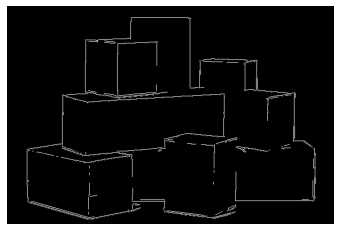

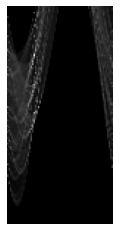

[1, 611] [165.0, 164.99999999999997]
[1, 611] [360.0, 359.99999999999994]
[1, 611] [265.0, 264.99999999999994]
[1, 611] [195.65737965742682, 142.2892949066132]
[1, 611] [406.4595455415298, 353.09146079071616]
[1, 611] [225.94695211077908, 279.3150368615928]
[340, 340] [1, 407]
[230, 230] [1, 407]
[1, 611] [30.639125337280813, 138.19858356944442]
[1, 611] [115.52676998101087, 168.89485473182455]
[145, 145] [1, 407]
[1, 611] [65.0, 64.99999999999996]
[535, 535] [1, 407]
[178, 249] [1.7033293418163566, 404.36433853467145]
[100, 100] [1, 407]
[422, 456] [397.0574550144984, 8.435676720612719]
[80, 611] [407.8777406725765, 36.06753788322061]
[1, 366] [196.87644179366237, 407.6092900478757]
[575, 575] [1, 407]
[332, 611] [407.97343470970713, 333.2156100214239]


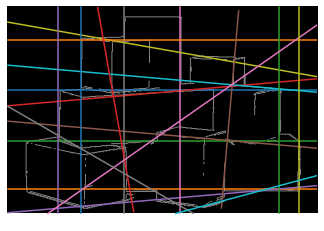

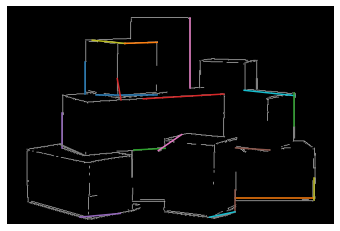

총 196608 strong 2913 weak 5378
5378 중 638 개 strong에 추가
1 번째로 큰 vote 수: 390.0 ( 165 90 )
2 번째로 큰 vote 수: 347.0 ( 40 115 )
3 번째로 큰 vote 수: 320.0 ( 285 55 )
4 번째로 큰 vote 수: 265.0 ( 80 110 )
5 번째로 큰 vote 수: 243.0 ( 125 100 )
6 번째로 큰 vote 수: 210.0 ( 205 90 )
7 번째로 큰 vote 수: 206.0 ( 0 300 )
8 번째로 큰 vote 수: 203.0 ( 365 95 )
9 번째로 큰 vote 수: 188.0 ( 0 120 )
10 번째로 큰 vote 수: 172.0 ( 245 85 )
11 번째로 큰 vote 수: 163.0 ( 315 75 )
12 번째로 큰 vote 수: 126.0 ( 50 305 )
13 번째로 큰 vote 수: 96.0 ( 95 310 )
14 번째로 큰 vote 수: 90.0 ( 180 340 )
15 번째로 큰 vote 수: 89.0 ( 395 60 )
16 번째로 큰 vote 수: 77.0 ( 105 15 )
17 번째로 큰 vote 수: 75.0 ( 235 325 )
18 번째로 큰 vote 수: 71.0 ( 270 330 )
19 번째로 큰 vote 수: 70.0 ( 140 20 )
20 번째로 큰 vote 수: 67.0 ( 30 0 )
segment 개수 3
직선 1 : [169 141] [166 470]
segment 개수 1
직선 2 : [168 255] [285 510]
segment 개수 1
직선 3 : [347   1] [168 264]
segment 개수 2
직선 4 : [201 319] [273 503]
segment 개수 3
직선 5 : [168 208] [188 331]
segment 개수 6
직선 6 : [205 416] [209 510]
segment 개수 4
직선 7 : [224 387] [284 500]
se

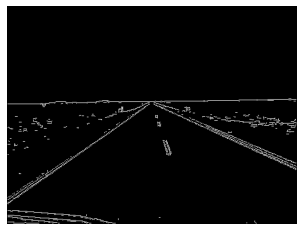

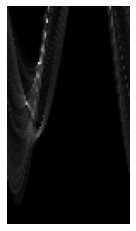

[1, 511] [165.0, 164.99999999999997]
[1, 511] [44.60142441665466, 282.4183300757038]
[1, 496] [347.22055025880525, 0.6178188449989079]
[1, 511] [85.49819203233918, 271.12301150810237]
[1, 511] [127.1046534664266, 217.0314136277437]
[1, 511] [205.0, 204.99999999999997]
[1, 511] [0.5773502691896258, 295.02598755589884]
[1, 201] [366.4817293668477, 383.9794620720325]
[1, 511] [0.5773502691896254, 295.0259875558986]
[1, 511] [245.84837153459418, 201.22915313637296]
[1, 511] [325.8440476367451, 189.1899594968725]
[88, 511] [0.5795339243816571, 296.76732258708887]
[148, 511] [0.17305292767096603, 304.76621904502355]
[192, 331] [1.2308725059318704, 383.13023381012454]
[125, 511] [383.9379290111011, 161.08072510390554]
[6, 108] [383.29654219599547, 2.6273598239699822]
[287, 511] [0.16848096402873125, 320.07363447426206]
[312, 511] [0.39985196148961677, 345.07796266769583]
[10, 148] [381.857841828286, 2.7059579435480714]
[30, 30] [1, 383]


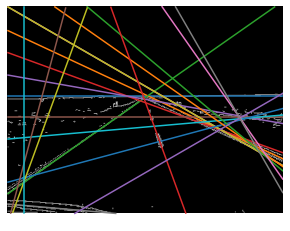

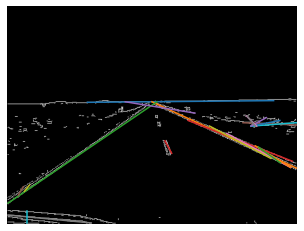

총 221184 strong 4467 weak 3646
3646 중 192 개 strong에 추가
1 번째로 큰 vote 수: 676.0 ( 240 90 )
2 번째로 큰 vote 수: 536.0 ( 270 85 )
3 번째로 큰 vote 수: 455.0 ( 205 95 )
4 번째로 큰 vote 수: 318.0 ( 310 80 )
5 번째로 큰 vote 수: 222.0 ( 340 75 )
6 번째로 큰 vote 수: 194.0 ( 370 75 )
7 번째로 큰 vote 수: 166.0 ( 75 110 )
8 번째로 큰 vote 수: 148.0 ( 400 70 )
9 번째로 큰 vote 수: 137.0 ( 10 115 )
10 번째로 큰 vote 수: 121.0 ( 440 65 )
11 번째로 큰 vote 수: 120.0 ( 35 300 )
12 번째로 큰 vote 수: 107.0 ( 85 305 )
13 번째로 큰 vote 수: 103.0 ( 470 60 )
14 번째로 큰 vote 수: 95.0 ( 130 310 )
15 번째로 큰 vote 수: 90.0 ( 505 55 )
16 번째로 큰 vote 수: 90.0 ( 190 315 )
17 번째로 큰 vote 수: 84.0 ( 220 320 )
18 번째로 큰 vote 수: 75.0 ( 540 50 )
19 번째로 큰 vote 수: 73.0 ( 260 330 )
20 번째로 큰 vote 수: 72.0 ( 395 340 )
segment 개수 1
직선 1 : [244 162] [243 574]
segment 개수 4
직선 2 : [260 121] [246 299]
segment 개수 3
직선 3 : [237 357] [256 574]
segment 개수 3
직선 4 : [255 337] [229 512]
segment 개수 1
직선 5 : [277 278] [229 476]
segment 개수 2
직선 6 : [263 447] [230 574]
segment 개수 1
직선 7 : [228 394] [278 5

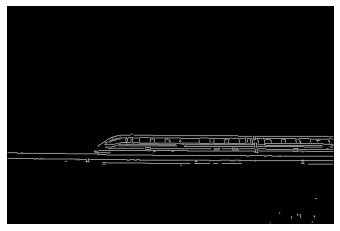

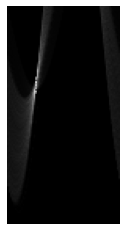

[1, 575] [240.0, 239.99999999999997]
[1, 575] [270.9438674731779, 220.7253746092975]
[1, 575] [205.87055535991215, 256.08904822379253]
[1, 575] [314.6059227038725, 213.39423577721357]
[1, 575] [351.72595214699714, 197.9231156915327]
[1, 575] [382.78423755929964, 228.9814011038352]
[1, 575] [80.17730316995961, 289.09621763875975]
[115, 575] [383.8145320497516, 216.38822428729847]
[1, 575] [11.500086847779913, 279.160682628749]
[218, 575] [383.83121486570667, 217.3593809043722]
[70, 575] [7.105427357601002e-15, 291.56188594076104]
[149, 575] [0.5650831485229872, 298.85349442585937]
[275, 575] [383.9379290111011, 210.7328482542133]
[203, 575] [0.6342775157916094, 312.7793403137397]
[333, 575] [383.32205710070195, 213.87183285395218]
[269, 575] [0.29942314911187395, 306.29942314911176]
[288, 575] [0.9657927578416547, 342.9990738323797]
[383, 575] [383.54477749853226, 222.4376483124945]
[301, 521] [1.3472930782319281, 382.39847074338456]
[421, 560] [1.7852555259767087, 383.68461683016926]


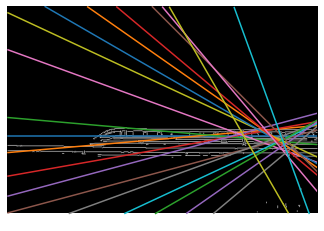

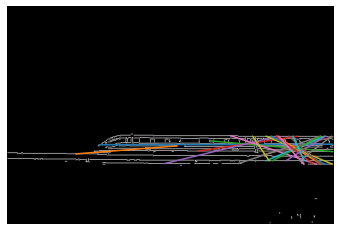

총 116640 strong 3670 weak 3828
3828 중 939 개 strong에 추가
1 번째로 큰 vote 수: 321.0 ( 230 45 )
2 번째로 큰 vote 수: 309.0 ( 275 90 )
3 번째로 큰 vote 수: 219.0 ( 15 315 )
4 번째로 큰 vote 수: 214.0 ( 185 110 )
5 번째로 큰 vote 수: 210.0 ( 320 355 )
6 번째로 큰 vote 수: 187.0 ( 305 65 )
7 번째로 큰 vote 수: 164.0 ( 60 325 )
8 번째로 큰 vote 수: 156.0 ( 90 330 )
9 번째로 큰 vote 수: 151.0 ( 310 35 )
10 번째로 큰 vote 수: 151.0 ( 260 340 )
11 번째로 큰 vote 수: 148.0 ( 350 15 )
12 번째로 큰 vote 수: 147.0 ( 150 115 )
13 번째로 큰 vote 수: 124.0 ( 5 130 )
14 번째로 큰 vote 수: 124.0 ( 115 140 )
15 번째로 큰 vote 수: 123.0 ( 355 55 )
16 번째로 큰 vote 수: 118.0 ( 120 335 )
17 번째로 큰 vote 수: 109.0 ( 385 40 )
18 번째로 큰 vote 수: 108.0 ( 20 170 )
19 번째로 큰 vote 수: 108.0 ( 75 15 )
20 번째로 큰 vote 수: 107.0 ( 50 120 )
segment 개수 3
직선 1 : [297  28] [135 195]
segment 개수 5
직선 2 : [275 148] [279 304]
segment 개수 3
직선 3 : [146 167] [240 267]
segment 개수 8
직선 4 : [287 247] [309 302]
segment 개수 23
직선 5 : [ 90 333] [131 333]
segment 개수 6
직선 6 : [322  33] [297  95]
segment 개수 5
직선 7 : [261 256]

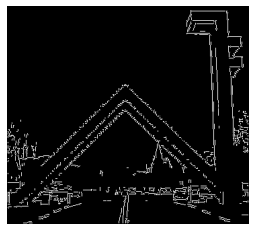

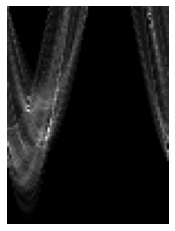

[2, 325] [323.2691193458118, 0.26911934581175956]
[1, 359] [275.0, 275.0]
[22, 345] [0.7867965644035699, 323.7867965644034]
[1, 349] [197.23685814230993, 323.89849966694834]
[322, 349] [8.888602874798835, 317.5000150493547]
[27, 359] [323.939958513375, 169.12581600591548]
[74, 300] [1.0761447616505677, 323.8375942853682]
[104, 290] [0.13328398716322454, 322.294734194974]
[152, 359] [323.390009617739, 27.763372222121234]
[277, 359] [0.8621011465278343, 226.15524954180694]
[276, 359] [322.25013391568564, 12.48991688746878]
[1, 339] [165.97299550252873, 323.5849839589182]
[1, 359] [7.366136077838673, 307.7638040393049]
[1, 121] [180.09999368154158, 323.11042479284674]
[157, 359] [323.4423955113925, 182.00047279303107]
[133, 283] [1.275230449471394, 322.9512685259046]
[231, 359] [323.65859345199624, 171.11413359993736]
[1, 36] [120.84669148249044, 319.34155516911034]
[1, 77] [286.04569707915164, 2.409835703916997]
[1, 359] [58.3123771881522, 265.0037735580381]


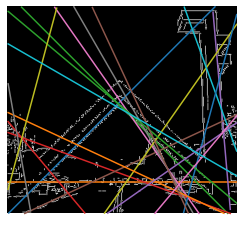

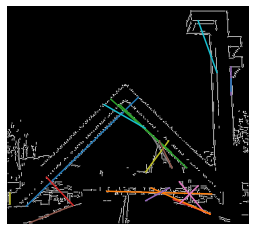

In [222]:
def main():
    
    parameters()
    
    # read images
    if not os.path.exists(resultdir):
        os.makedirs(resultdir)
    image_number = 0
    for img_path in glob.glob(datadir+'/*.jpg'):
        
        # edgedetection
        sigma=sigma[i]
        highThreshold=highThreshold[i] #max에서 몇퍼센트
        lowThreshold=lowThreshold[i]   #highThreshold에서 몇퍼센트
        #houghline
        rhoRes=rhoRes[i]
        thetaRes=thetaRes[i] 
        rhoTh=rhoTh[i]  #rhoRes * rhoTh 만큼 non maximal suppression
        thetaTh=thetaTh[i] #thetaRes * thetaTh 만큼 non maximal suppression
        interval=interval[i]

        
        # load grayscale image
        img = Image.open(img_path).convert("L")
        Igs = np.array(img)
        Igs = Igs / 255.

        # Hough function
        Im, Io, Ix, Iy = EdgeDetection(Igs.copy(), sigma, highTh, lowTh)
        H= HoughTransform(Im.copy(), rhoRes, thetaRes)
        lRho,lTheta =HoughLines(H.copy(),rhoRes,thetaRes,nLines,rhothreshold,thetathreshold)
        l = HoughLineSegments(lRho.copy(), lTheta.copy(), Im.copy())

        # saves the outputs to files
        # Im, H, Im + hough line , Im + hough line segments
        
        plt.figure()
        plt.imshow(Im,cmap='gray')
        plt.axis('off')
        plt.savefig(resultdir +'/img'+ str(image_number+1) +'_Im.jpeg')
        plt.show()

        plt.figure()
        plt.imshow(H,cmap='gray')
        plt.axis('off')
        plt.savefig(resultdir +'/img'+ str(image_number+1) +'_H.jpeg')
        plt.show()

        plt.figure()
        plt.imshow(Im,cmap='gray')
        plt.axis('off')
        drawhoughline(Igs,lRho,lTheta)
        plt.savefig(resultdir +'/img'+ str(image_number+1) +'_Im + houghline.jpeg')
        plt.show()

        plt.figure()
        plt.imshow(Im,cmap='gray')
        plt.axis('off')
        drawsegments(l)
        plt.savefig(resultdir +'/img'+ str(image_number+1) +'_Im + houghtlinesegments.jpeg')
        plt.show()  
        
        image_number += 1
    

if __name__ == '__main__':
    main()

In [219]:
a = np.array([[1,2,3,4,5],[2,3,4,5,6],[6,5,4,3,2],[1,4,3,5,2],[3,4,5,6,4],[23,3,32,3,3]])
nonzero = np.transpose(np.nonzero(a))
th =2
h,w = a.shape

for nz in nonzero:
        U = nz[0]-th
        D = nz[0]+th+1
        L = nz[1]-th
        R = nz[1]+th+1
        if (nz[0]<th): 
            U = 0
        if (nz[0]>=h-th):
            D = h
        if (nz[1]<th):
            L = 0
        if (nz[1]>=w-th):
            print(nz,list(range(0,R-w,1)))
            R = w
        
        if (np.any(a[U:D,L:R]>a[nz[0],nz[1]])):
            a[nz[0],nz[1]] = 0
print(a)



[0 3] [0]
[0 4] [0, 1]
[1 3] [0]
[1 4] [0, 1]
[2 3] [0]
[2 4] [0, 1]
[3 3] [0]
[3 4] [0, 1]
[4 3] [0]
[4 4] [0, 1]
[5 3] [0]
[5 4] [0, 1]
[[ 0  0  0  0  0]
 [ 0  0  0  0  6]
 [ 6  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0 32  0  0]]


In [177]:
b = list({1,2,3})
del b[1]
b

[1, 3]

In [85]:
x[1] < x[0:2]

array([False, False])